## Jupyter notebook for testing an image

Code from [tests/test_snapshot.py](tests/test_snapshot.py)

required packages 

1. Tensorflow

2. Other packages
```
pip install tqdm chainer
```

In [2]:
import numpy as np
import copy
import os
import sys
import math
from tqdm import tqdm
from scripts import dataset
import scripts.regressionnet
from scripts.regressionnet import batch2feeds, calculate_metric


from scripts import config

In [4]:

%load_ext autoreload
%autoreload 2


# this was main function
dataset_name = 'met'

if dataset_name not in ['met', 'lsp', 'mpii']:
    raise ValueError('Unknown dataset: {}'.format(dataset_name))

if dataset_name == 'mpii':
    TEST_CV_FILEPATH = os.path.join(config.MPII_DATASET_ROOT, 'test_joints.csv')
    IMG_PATH_PREFIX = os.path.join(config.MPII_DATASET_ROOT, 'images')
    symmetric_joints = "[[12, 13], [11, 14], [10, 15], [2, 3], [1, 4], [0, 5]]"
    ignore_label = -100500
elif dataset_name == 'lsp': # LSP dataset
    TEST_CV_FILEPATH = os.path.join(config.LSP_DATASET_ROOT, 'test_joints.csv')
    IMG_PATH_PREFIX = os.path.join(config.LSP_DATASET_ROOT, 'images')
    symmetric_joints = "[[8, 9], [7, 10], [6, 11], [2, 3], [1, 4], [0, 5]]"
    ignore_label = -1
elif dataset_name == 'met': # MET dataset
    #TEST_CV_FILEPATH = os.path.join(config.MET_DATASET_ROOT, 'activity1.csv') # test only one image
    TEST_CV_FILEPATH = os.path.join(config.MET_DATASET_ROOT, 'activity.csv')
    IMG_PATH_PREFIX = os.path.join(config.MET_DATASET_ROOT)
    symmetric_joints = "[[8, 9], [7, 10], [6, 11], [2, 3], [1, 4], [0, 5]]"
    ignore_label = -1
else:
    pass
 
    
print(TEST_CV_FILEPATH)
print(IMG_PATH_PREFIX)

test_dataset = dataset.PoseDataset(
    TEST_CV_FILEPATH,
    IMG_PATH_PREFIX, 227,
    fliplr=False, rotate=False,
    shift=None,
    bbox_extension_range=(1.0, 1.0),
    coord_normalize=True,
    gcn=True,
    fname_index=0,
    joint_index=1,
    symmetric_joints=symmetric_joints,
    ignore_label=ignore_label,
    should_return_bbox=True,
    should_downscale_images=True,
    downscale_height=400
)

print("data ready")



14it [00:00, 128.26it/s]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/var/data/MET2/activity.csv
/var/data/MET2
Reading dataset from /var/data/MET2/activity.csv
Downscale images to the height 400px


317it [00:02, 145.32it/s]/home/yyoo/src/deeppose/scripts/dataset.py:145: UserWarning: Skipping joint with incorrect joints coordinates. They are out of the image.
image: /var/data/MET2/image/office activities/lifting.packing/packing/41.png, joint: [421. 779.], im.shape: (328, 622)
  'image: {}, joint: {}, im.shape: {}'.format(img_path, joints[i_joint], image_shape[:2]))
959it [00:04, 191.83it/s]

Joints shape: (14, 2)
data ready


In [19]:
test_dataset.get_original_image(1)

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [5]:
# load creat regressionnet and load weight from snapshot 

snapshot_path = '/var/data/out/lsp_alexnet_imagenet/checkpoint-1000000'
# init_snapshot_path = os.path.join(config.ROOT_DIR, 'out/mpii_alexnet_imagenet/checkpoint-10000')
# init_snapshot_path = os.path.join(config.ROOT_DIR, 'out/lsp_alexnet_scratch/checkpoint-10000')

from scripts import regressionnet

net, loss_op, pose_loss_op, train_op = regressionnet.create_regression_net(
    n_joints=16 if dataset_name == 'mpii' else 14,
    init_snapshot_path=snapshot_path,
    is_resume=True,
    net_type='Alexnet',
    optimizer_type='momentum',
    gpu_memory_fraction=0.32)  # Set how much GPU memory to reserve for the network

print(net)
print(snapshot_path)

Alexnet::__create_architecture()
Initializing conv1 with random
Initializing conv2 with random
Initializing conv3 with random
Initializing conv4 with random
Initializing conv5 with random
Initializing fc6 with random
Initializing fc7 with random
Initializing fc8 with random
Initializing layer 99 with random
Restoring everything from snapshot and resuming from /var/data/out/lsp_alexnet_imagenet/checkpoint-1000000
INFO:tensorflow:Restoring parameters from /var/data/out/lsp_alexnet_imagenet/checkpoint-1000000


INFO:tensorflow:Restoring parameters from /var/data/out/lsp_alexnet_imagenet/checkpoint-1000000


Creating optimizer momentum
Conv LR: Tensor("lr/conv_lr:0", shape=(), dtype=float32), FC LR: Tensor("lr/fc_lr:0", shape=(), dtype=float32)
INFO:tensorflow:Summary name grad_norms/conv1/weight:0 is illegal; using grad_norms/conv1/weight_0 instead.


INFO:tensorflow:Summary name grad_norms/conv1/weight:0 is illegal; using grad_norms/conv1/weight_0 instead.


INFO:tensorflow:Summary name grad_norms/conv1/bias:0 is illegal; using grad_norms/conv1/bias_0 instead.


INFO:tensorflow:Summary name grad_norms/conv1/bias:0 is illegal; using grad_norms/conv1/bias_0 instead.


INFO:tensorflow:Summary name grad_norms/conv2/weight:0 is illegal; using grad_norms/conv2/weight_0 instead.


INFO:tensorflow:Summary name grad_norms/conv2/weight:0 is illegal; using grad_norms/conv2/weight_0 instead.


INFO:tensorflow:Summary name grad_norms/conv2/bias:0 is illegal; using grad_norms/conv2/bias_0 instead.


INFO:tensorflow:Summary name grad_norms/conv2/bias:0 is illegal; using grad_norms/conv2/bias_0 instead.


INFO:tensorflow:Summary name grad_norms/conv3/weight:0 is illegal; using grad_norms/conv3/weight_0 instead.


INFO:tensorflow:Summary name grad_norms/conv3/weight:0 is illegal; using grad_norms/conv3/weight_0 instead.


INFO:tensorflow:Summary name grad_norms/conv3/bias:0 is illegal; using grad_norms/conv3/bias_0 instead.


INFO:tensorflow:Summary name grad_norms/conv3/bias:0 is illegal; using grad_norms/conv3/bias_0 instead.


INFO:tensorflow:Summary name grad_norms/conv4/weight:0 is illegal; using grad_norms/conv4/weight_0 instead.


INFO:tensorflow:Summary name grad_norms/conv4/weight:0 is illegal; using grad_norms/conv4/weight_0 instead.


INFO:tensorflow:Summary name grad_norms/conv4/bias:0 is illegal; using grad_norms/conv4/bias_0 instead.


INFO:tensorflow:Summary name grad_norms/conv4/bias:0 is illegal; using grad_norms/conv4/bias_0 instead.


INFO:tensorflow:Summary name grad_norms/conv5/weight:0 is illegal; using grad_norms/conv5/weight_0 instead.


INFO:tensorflow:Summary name grad_norms/conv5/weight:0 is illegal; using grad_norms/conv5/weight_0 instead.


INFO:tensorflow:Summary name grad_norms/conv5/bias:0 is illegal; using grad_norms/conv5/bias_0 instead.


INFO:tensorflow:Summary name grad_norms/conv5/bias:0 is illegal; using grad_norms/conv5/bias_0 instead.


INFO:tensorflow:Summary name grad_norms/fc6/weight:0 is illegal; using grad_norms/fc6/weight_0 instead.


INFO:tensorflow:Summary name grad_norms/fc6/weight:0 is illegal; using grad_norms/fc6/weight_0 instead.


INFO:tensorflow:Summary name grad_norms/fc6/bias:0 is illegal; using grad_norms/fc6/bias_0 instead.


INFO:tensorflow:Summary name grad_norms/fc6/bias:0 is illegal; using grad_norms/fc6/bias_0 instead.


INFO:tensorflow:Summary name grad_norms/fc7/weight:0 is illegal; using grad_norms/fc7/weight_0 instead.


INFO:tensorflow:Summary name grad_norms/fc7/weight:0 is illegal; using grad_norms/fc7/weight_0 instead.


INFO:tensorflow:Summary name grad_norms/fc7/bias:0 is illegal; using grad_norms/fc7/bias_0 instead.


INFO:tensorflow:Summary name grad_norms/fc7/bias:0 is illegal; using grad_norms/fc7/bias_0 instead.


INFO:tensorflow:Summary name grad_norms/fc_regression/weight:0 is illegal; using grad_norms/fc_regression/weight_0 instead.


INFO:tensorflow:Summary name grad_norms/fc_regression/weight:0 is illegal; using grad_norms/fc_regression/weight_0 instead.


INFO:tensorflow:Summary name grad_norms/fc_regression/bias:0 is illegal; using grad_norms/fc_regression/bias_0 instead.


INFO:tensorflow:Summary name grad_norms/fc_regression/bias:0 is illegal; using grad_norms/fc_regression/bias_0 instead.


uninit vars: ['conv1/weight/Momentum:0', 'conv1/bias/Momentum:0', 'conv2/weight/Momentum:0', 'conv2/bias/Momentum:0', 'conv3/weight/Momentum:0', 'conv3/bias/Momentum:0', 'conv4/weight/Momentum:0', 'conv4/bias/Momentum:0', 'conv5/weight/Momentum:0', 'conv5/bias/Momentum:0', 'fc6/weight/Momentum:0', 'fc6/bias/Momentum:0', 'fc7/weight/Momentum:0', 'fc7/bias/Momentum:0', 'fc_regression/weight/Momentum:0', 'fc_regression/bias/Momentum:0']
Elapsed time for finding uninitialized variables: 0.45s
Elapsed time to init them: 0.25s
/var/data/out/lsp_alexnet_imagenet/checkpoint-1000000


In [6]:
print("start testing")

# predict joints
batch_size=128
avg_loss, global_step, gt_joints, gt_joints_is_valid, predicted_joints, orig_bboxes = regressionnet.predict(net, pose_loss_op, test_dataset, batch_size, dataset_name=dataset_name, tag_prefix='test')

  0%|          | 0/8 [00:00<?, ?it/s]

start testing
958


100%|██████████| 8/8 [00:04<00:00,  1.83it/s]

Step 1000000 test/pose_loss = 0.185


In [7]:
print(gt_joints.shape)
print(gt_joints)
print(predicted_joints.shape)
print(predicted_joints)

(958, 14, 2)
[[[-0.19162995  0.42951542]
  [-0.19162995  0.24008811]
  [ 0.31057268  0.01101321]
  ...
  [-0.5        -0.01982379]
  [-0.00220263 -0.3634361 ]
  [-0.02422908 -0.5       ]]

 [[-0.03744492  0.49118942]
  [-0.09030837  0.27973568]
  [-0.21806169  0.02422905]
  ...
  [ 0.47797358  0.01101321]
  [ 0.01541853 -0.37224668]
  [-0.00220263 -0.5       ]]

 [[ 0.12555069  0.49559474]
  [ 0.12555069  0.26651984]
  [ 0.01541853  0.03303963]
  ...
  [ 0.11233479 -0.00220263]
  [ 0.07709253 -0.39427313]
  [ 0.12555069 -0.5       ]]

 ...

 [[-0.28854626  0.49118942]
  [-0.28854626  0.27973568]
  [-0.26651984  0.09911895]
  ...
  [ 0.08590311 -0.04185021]
  [ 0.12555069 -0.3634361 ]
  [ 0.12555069 -0.5       ]]

 [[-0.27973568  0.49118942]
  [-0.08590308  0.20925111]
  [-0.02863437  0.05947137]
  ...
  [ 0.3325991  -0.06828195]
  [ 0.13876653 -0.37665197]
  [ 0.35903084 -0.5       ]]

 [[-0.5         0.46475768]
  [-0.38986784  0.29735684]
  [-0.25330395  0.11674011]
  ...
  [ 0.33259

In [15]:
# save predicted joints coordination to prectedJointsMET_1000_14.txt
n, numJoints, dim = predicted_joints.shape
np.savetxt('prectedJointsMET_{}_{}.txt'.format(n,numJoints),predicted_joints.reshape(-1,numJoints*dim), delimiter=',')

# TODO: convert to image coordinate before saving!


[[-0.5        -0.5       ]
 [-0.5        -0.5       ]
 [-0.5        -0.5       ]
 [-0.5        -0.5       ]
 [-0.5        -0.5       ]
 [-0.5        -0.5       ]
 [-0.13436124  0.24889868]
 [-0.20484582  0.18281937]
 [-0.02863437 -0.09471366]
 [ 0.28854626 -0.06387666]
 [ 0.31057268  0.26211452]
 [ 0.09030837  0.26211452]
 [ 0.12114537 -0.03303966]
 [ 0.15198237 -0.37665197]]
[[ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]]
{'bbox': array([  0,   0, 251, 201]), 'orig_tightest_bbox': array([  0.,   0., 204., 154.]), 'image_id': 'image/office activities/writing/46.jpeg'}


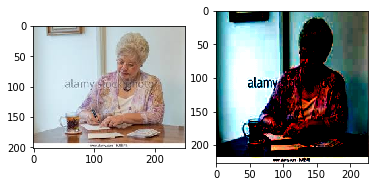

In [40]:
from matplotlib import pyplot as plt
%matplotlib inline

imageIdx = 101   # this image has only upper body
img=test_dataset.get_original_image(imageIdx)


image, joints, is_valid_joints, misc = test_dataset.get_example(imageIdx)

plt.subplot(121)
plt.imshow(img[:,:,::-1])
plt.subplot(122)
plt.imshow(image[:,:,::-1])

print(joints)
print(is_valid_joints)   # NOT CORRECT!!!
print(misc)

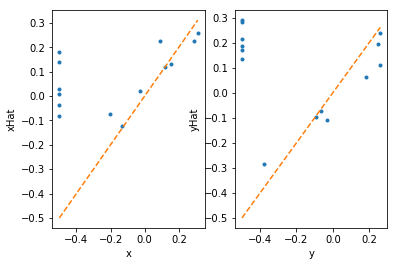

In [32]:

x = gt_joints[imageIdx][:,0]
xhat = predicted_joints[imageIdx][:,0]
y = gt_joints[imageIdx][:,1]
yhat = predicted_joints[imageIdx][:,1]


plt.subplot(121)
plt.plot(x,xhat,'.')
plt.xlabel('x');plt.ylabel('xHat');
plt.plot([min(x), max(x)], [min(x), max(x)],'--')
plt.subplot(122)
plt.plot(y,yhat,'.')
plt.plot([min(y), max(y)], [min(y), max(y)],'--')
plt.xlabel('y');plt.ylabel('yHat');

In [33]:
gt_joints_is_valid[imageIdx]

array([[ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True]])

In [10]:
#gt_joints_is_valid.shape       # (954, 14, 2)
numSamples, numJoints, dim = gt_joints_is_valid.shape
print(numSamples, numJoints, dim)

for i in range(numSamples):
    #print(i)
    print(gt_joints_is_valid[i])
    

958 14 2
[[ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]]
[[ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]]
[[ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]]
[[ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]]
[[ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  Tru

In [11]:
# calc PCP
PCPs = list()
for ext in np.linspace(1.0, 2.0, 6, True):
    print('\n====================')
    print('BBOX EXTENSION:', ext)
    test_dataset.bbox_extension_range = (ext, ext)
    

    # predict joints
    batch_size=128
    avg_loss, global_step, gt_joints, gt_joints_is_valid, predicted_joints, orig_bboxes = regressionnet.predict(net, pose_loss_op, test_dataset, batch_size, dataset_name=dataset_name, tag_prefix='test')

    
    # calc metric
    pcp_per_stick = scripts.regressionnet.calc_pcp(global_step, gt_joints, gt_joints_is_valid, predicted_joints, orig_bboxes, dataset_name)        
    PCPs.append(pcp_per_stick[0])

  0%|          | 0/8 [00:00<?, ?it/s]


BBOX EXTENSION: 1.0
958


100%|██████████| 8/8 [00:04<00:00,  1.84it/s]


Step 1000000 test/pose_loss = 0.185
met


/home/yyoo/src/deeppose/poseevaluation/pcp.py:88: RuntimeWarning: divide by zero encountered in float_scalars
  gt_joints[i]['sticks'][stick_id, :2]) / gt_stick_len
/home/yyoo/src/deeppose/poseevaluation/pcp.py:90: RuntimeWarning: divide by zero encountered in float_scalars
  gt_joints[i]['sticks'][stick_id, 2:]) / gt_stick_len


Step	 1000000	 test/mPCP	 0.174
Step 1000000 test/parts_PCP:
Head	Torso	U Arm	L Arm	U Leg	L Leg	mean
0.325	0.383	0.134	0.034	0.101	0.066	0.174
met


/home/yyoo/src/deeppose/poseevaluation/pcp.py:51: RuntimeWarning: divide by zero encountered in float_scalars
  gt_joints[i]['sticks'][stick_id, :2]) / gt_stick_len
/home/yyoo/src/deeppose/poseevaluation/pcp.py:53: RuntimeWarning: divide by zero encountered in float_scalars
  gt_joints[i]['sticks'][stick_id, 2:]) / gt_stick_len


Step	 1000000	 test/mRelaxedPCP	 0.314
Step 1000000 test/parts_RelaxedPCP:
Head	Torso	U Arm	L Arm	U Leg	L Leg	mean
0.492	0.640	0.289	0.090	0.232	0.141	0.314
met


/home/yyoo/src/deeppose/poseevaluation/pcp.py:134: RuntimeWarning: divide by zero encountered in double_scalars
  gt_joints[i]['joints'][joint_id]) / gt_head_len
  0%|          | 0/8 [00:00<?, ?it/s]

Step	 1000000	 test/mPCKh	 0.206
Step	 1000000	 test/mSymmetricPCKh	 0.241
Step 1000000 test/parts_SymmetricPCKh:
Head	Neck	Shoulder	Elbow	Wrist	Hip	Knee	Ankle	Thorax	Pelvis
0.406	0.568	0.373	0.169	0.180	0.140	0.066	0.028

BBOX EXTENSION: 1.2
958


100%|██████████| 8/8 [00:04<00:00,  1.93it/s]


Step 1000000 test/pose_loss = 0.147
met
Step	 1000000	 test/mPCP	 0.269
Step 1000000 test/parts_PCP:
Head	Torso	U Arm	L Arm	U Leg	L Leg	mean
0.473	0.491	0.263	0.073	0.173	0.144	0.269
met
Step	 1000000	 test/mRelaxedPCP	 0.415
Step 1000000 test/parts_RelaxedPCP:
Head	Torso	U Arm	L Arm	U Leg	L Leg	mean
0.641	0.694	0.444	0.151	0.322	0.239	0.415
met


  0%|          | 0/8 [00:00<?, ?it/s]

Step	 1000000	 test/mPCKh	 0.296
Step	 1000000	 test/mSymmetricPCKh	 0.338
Step 1000000 test/parts_SymmetricPCKh:
Head	Neck	Shoulder	Elbow	Wrist	Hip	Knee	Ankle	Thorax	Pelvis
0.530	0.731	0.515	0.265	0.242	0.197	0.128	0.097

BBOX EXTENSION: 1.4
958


100%|██████████| 8/8 [00:04<00:00,  1.90it/s]


Step 1000000 test/pose_loss = 0.135
met
Step	 1000000	 test/mPCP	 0.287
Step 1000000 test/parts_PCP:
Head	Torso	U Arm	L Arm	U Leg	L Leg	mean
0.454	0.513	0.291	0.081	0.204	0.181	0.287
met
Step	 1000000	 test/mRelaxedPCP	 0.425
Step 1000000 test/parts_RelaxedPCP:
Head	Torso	U Arm	L Arm	U Leg	L Leg	mean
0.624	0.685	0.458	0.169	0.349	0.267	0.425
met


  0%|          | 0/8 [00:00<?, ?it/s]

Step	 1000000	 test/mPCKh	 0.313
Step	 1000000	 test/mSymmetricPCKh	 0.350
Step 1000000 test/parts_SymmetricPCKh:
Head	Neck	Shoulder	Elbow	Wrist	Hip	Knee	Ankle	Thorax	Pelvis
0.513	0.713	0.528	0.290	0.266	0.222	0.142	0.128

BBOX EXTENSION: 1.6
958


100%|██████████| 8/8 [00:04<00:00,  1.91it/s]


Step 1000000 test/pose_loss = 0.131
met
Step	 1000000	 test/mPCP	 0.285
Step 1000000 test/parts_PCP:
Head	Torso	U Arm	L Arm	U Leg	L Leg	mean
0.442	0.508	0.280	0.090	0.208	0.181	0.285
met
Step	 1000000	 test/mRelaxedPCP	 0.423
Step 1000000 test/parts_RelaxedPCP:
Head	Torso	U Arm	L Arm	U Leg	L Leg	mean
0.612	0.687	0.451	0.171	0.354	0.265	0.423
met


  0%|          | 0/8 [00:00<?, ?it/s]

Step	 1000000	 test/mPCKh	 0.310
Step	 1000000	 test/mSymmetricPCKh	 0.346
Step 1000000 test/parts_SymmetricPCKh:
Head	Neck	Shoulder	Elbow	Wrist	Hip	Knee	Ankle	Thorax	Pelvis
0.500	0.700	0.518	0.297	0.257	0.225	0.142	0.128

BBOX EXTENSION: 1.8
958


100%|██████████| 8/8 [00:04<00:00,  1.85it/s]


Step 1000000 test/pose_loss = 0.130
met
Step	 1000000	 test/mPCP	 0.280
Step 1000000 test/parts_PCP:
Head	Torso	U Arm	L Arm	U Leg	L Leg	mean
0.433	0.508	0.272	0.088	0.205	0.173	0.280
met
Step	 1000000	 test/mRelaxedPCP	 0.411
Step 1000000 test/parts_RelaxedPCP:
Head	Torso	U Arm	L Arm	U Leg	L Leg	mean
0.579	0.678	0.445	0.168	0.340	0.253	0.411
met


  0%|          | 0/8 [00:00<?, ?it/s]

Step	 1000000	 test/mPCKh	 0.305
Step	 1000000	 test/mSymmetricPCKh	 0.341
Step 1000000 test/parts_SymmetricPCKh:
Head	Neck	Shoulder	Elbow	Wrist	Hip	Knee	Ankle	Thorax	Pelvis
0.494	0.683	0.504	0.292	0.266	0.232	0.138	0.118

BBOX EXTENSION: 2.0
958


100%|██████████| 8/8 [00:04<00:00,  1.91it/s]


Step 1000000 test/pose_loss = 0.129
met
Step	 1000000	 test/mPCP	 0.267
Step 1000000 test/parts_PCP:
Head	Torso	U Arm	L Arm	U Leg	L Leg	mean
0.408	0.486	0.260	0.086	0.195	0.168	0.267
met
Step	 1000000	 test/mRelaxedPCP	 0.400
Step 1000000 test/parts_RelaxedPCP:
Head	Torso	U Arm	L Arm	U Leg	L Leg	mean
0.565	0.667	0.433	0.163	0.330	0.241	0.400
met
Step	 1000000	 test/mPCKh	 0.296
Step	 1000000	 test/mSymmetricPCKh	 0.331
Step 1000000 test/parts_SymmetricPCKh:
Head	Neck	Shoulder	Elbow	Wrist	Hip	Knee	Ankle	Thorax	Pelvis
0.471	0.670	0.491	0.286	0.255	0.228	0.131	0.114


[[0.32463466 0.38308977 0.13361169 0.03757829 0.10647182 0.06889353
  0.13361169 0.03131524 0.09498956 0.06263048]
 [0.47286013 0.49060543 0.24634656 0.06993737 0.16388309 0.13778706
  0.27974948 0.07515658 0.18267223 0.15031315]
 [0.45407098 0.5125261  0.28496868 0.07933194 0.20041754 0.17223382
  0.29749478 0.08246347 0.20668058 0.18997912]
 [0.44154489 0.50835073 0.28705637 0.08455115 0.21085595 0.17640919
  0.27348643 0.0960334  0.2045929  0.18580376]
 [0.43319415 0.50835073 0.27035491 0.08350731 0.20354906 0.16701461
  0.27453027 0.09290188 0.20668058 0.17954071]
 [0.40814196 0.48643006 0.25782881 0.08455115 0.19102296 0.15970772
  0.26304802 0.08768267 0.1993737  0.17640919]]


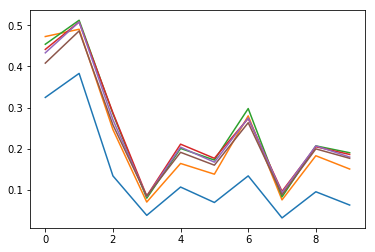

In [12]:
PCPs=np.vstack(PCPs)
print(PCPs)
plt.plot(np.asmatrix(PCPs).transpose())

In [13]:
# plot by parts

from poseevaluation.pcp import average_pcp_left_right_limbs
pcp_per_part, part_names = average_pcp_left_right_limbs(PCPs[1]) # BBOX_EXT = 1.2

print(part_names)
print(pcp_per_part)
    

['Head', 'Torso', 'U Arm', 'L Arm', 'U Leg', 'L Leg', 'mean']
[0.47286012526096033, 0.4906054279749478, 0.2630480167014614, 0.07254697286012526, 0.1732776617954071, 0.14405010438413363, 0.2693980514961726]


### Test one image

In [ ]:
pass

image_ori = test_dataset.images['image/office activities/walking about/1.png']
#?test_dataset
#test_dataset.get_example(0)
image, joints, is_valid_joints, misc = test_dataset.get_example(0)

# plot
from matplotlib import pyplot as plt
%matplotlib inline

plt.subplot(121)
plt.imshow(image_ori[:,:,::-1], interpolation = 'bicubic')
plt.subplot(122)
plt.imshow(image[:,:,::-1], interpolation = 'bicubic')

In [ ]:
from chainer import iterators
test_it = iterators.MultiprocessIterator(test_dataset, batch_size=batch_size,
                                             repeat=False, shuffle=False,
                                             n_processes=1, n_prefetch=1)
    # http://docs.chainer.org/en/stable/reference/generated/chainer.iterators.MultiprocessIterator.html

for i, batch in enumerate(test_it):
    print(batch[0][0].shape)
    print(batch[0][1].shape)
    print(batch[0][2].shape)

In [ ]:
# check image size
# img = test_dataset.images['image/office activities/walking about/1.png']
# print(img.shape)
# j = test_dataset.joints
# print(j)


# plot one image from the data
imageIdx = 0


img=test_dataset.get_original_image(imageIdx)
h,w,d=img.shape
print(h,w,d)  # 169 95 3

# joints has all the info loaded from test_joints.csv
img_id, joints = test_dataset.joints[imageIdx]
print(img_id)  # /var/data/lsp/images/im1001.jpg
print(joints)  # [[ 42.96321929 138.35880369]


#print(test_dataset.images)
img, joints, is_valid_joints, misc = test_dataset.get_example(imageIdx)
h,w,d=img.shape
print(h,w,d)   # 227 227 3
print(joints)  # [[-0.06828195  0.42070484]

#print(test_dataset[imageIdx][0].shape)
#print(test_dataset[imageIdx][1].shape)
#print(test_dataset[imageIdx][2].shape)


# calc PCP
for ext in np.linspace(1.0, 2.0, 6, True):
    print('\n====================')
    print('BBOX EXTENSION:', ext)
    test_dataset.bbox_extension_range = (ext, ext)
    

    # calc metric
    scripts.regressionnet.calc_pcp(global_step, gt_joints, gt_joints_is_valid, predicted_joints, orig_bboxes, dataset_name)
        
    """
    scripts.regressionnet.evaluate_pcp(net, pose_loss_op, test_iterator, None,
                                       dataset_name=dataset_name,
                                       tag_prefix='test')
    """

In [ ]:
# predict one image 
from cv2 import imread, resize

# load an image  (code from load_images in scripts/dataset.py)
img_path='/var/data/MET2/image/office activities/walking about/1.png'
image = imread(img_path)  # HWC BGR image
print(image.shape)
#downscale image if needed
downscale_height = 400
if image.shape[0] > downscale_height:
    downscale_factor = float(image.shape[0]) / self.downscale_height
    image = resize(image, None, fx=1.0/downscale_factor, fy=1.0/downscale_factor)
                


# code from predict in scripts/regressionnet.py

feed_dict = {
        net.x: image,   # should be in the shape of (?, 227, 227, 3)
        #'pose_input/joints_gt:0': joints_gt,
        #'pose_input/joints_is_valid:0': joints_is_valid,
        'input/is_phase_train:0': False,   # testing!
        'lr/conv_lr:0': 0.0,
        'lr/fc_lr:0': 0.0
    }

pred_j, batch_loss_value = net.sess.run([net.fc_regression, pose_loss_op], feed_dict=feed_dict)

In [ ]:
# code from regressionnet.fill_joint_feed_dict
def fill_joint_feed_dict(net, batch_feeds,
                         conv_lr=None, fc_lr=None,
                         phase='test', train_keep_prob=0.4):
    """Fills the feed_dict for training the given step.

    A feed_dict takes the form of:
    feed_dict = {
        <placeholder>: <tensor of values to be passed for placeholder>,
        ....
    }

    Args:
      batch_loader: BatchLoader, that provides batches of the data
      images_pl: The images placeholder, from placeholder_inputs().
      labels_pl: The labels placeholder, from placeholder_inputs().

    Returns:
      feed_dict: The feed dictionary mapping from placeholders to values.
    """
    if phase not in ['train', 'test']:
        raise ValueError('phase must be "train" or "test"')
    if phase == 'train':
        keep_prob = train_keep_prob
        is_phase_train = True
    else:
        keep_prob = 1.0
        is_phase_train = False

    if len(batch_feeds) != 3:
        raise ValueError('feeds must contain only 3 elements: images, joints_gt, joints_is_valid')
    images, joints_gt, joints_is_valid = batch_feeds

    feed_dict = {
        net.x: images,
        'pose_input/joints_gt:0': joints_gt,
        'pose_input/joints_is_valid:0': joints_is_valid,
        'input/is_phase_train:0': is_phase_train,
        'lr/conv_lr:0': conv_lr,
        'lr/fc_lr:0': fc_lr
    }

    try:
        keep_prob_pl = net.graph.get_tensor_by_name('input/dropout_keep_prob:0')
        dropout_params = {keep_prob_pl: keep_prob}
    except KeyError:
        dropout_params = {'fc6/keep_prob_pl:0': keep_prob,
                          'fc7/keep_prob_pl:0': keep_prob}
    feed_dict.update(dropout_params)
    return feed_dict

In [ ]:
# code from regressionnet.evaluate_pcp
summary_writer = None
tag_prefix='test'

total_loss = 0.0

num_joints = int(int(net.fc_regression.get_shape()[1]) / 2)
gt_joints = list()
gt_joints_is_valid = list()
predicted_joints = list()
orig_bboxes = list()
    

test_it = copy.copy(test_iterator)
num_test_examples = len(test_it.dataset)
num_batches = int(math.ceil(num_test_examples / test_it.batch_size))
for i, batch in tqdm(enumerate(test_it), total=num_batches):

        # uncomment a breakpoint here for debugging
        # import pdb; pdb.set_trace()

        feeds = batch2feeds(batch)
        feed_dict = fill_joint_feed_dict(net,
                                         feeds[:3],
                                         conv_lr=0.0,
                                         fc_lr=0.0,
                                         phase='test')

        pred_j, batch_loss_value = net.sess.run([net.fc_regression, pose_loss_op], feed_dict=feed_dict)
        total_loss += batch_loss_value * len(batch)
        predicted_joints.append(pred_j.reshape(-1, num_joints, 2))

        gt_joints.append(feeds[1])
        gt_joints_is_valid.append(feeds[2])
        orig_bboxes.append(np.vstack([x['bbox'] for x in feeds[3]]))

In [ ]:
# estimated joints
imageIdx = 0
print(predicted_joints[imageIdx][0].shape)
print(predicted_joints[imageIdx][0])
xhat = predicted_joints[imageIdx][0][:,0]
yhat = predicted_joints[imageIdx][0][:,1]

In [ ]:
import cv2
from matplotlib import pyplot as plt
%matplotlib inline


# plot example image (normalized)
img, joints, is_valid_joints, misc = test_dataset.get_example(imageIdx, gcn=None, bbox_extension_range=None, shift=None)
print(joints)

#img = test_dataset.get_original_image(imageIdx)  # 169 95 3


h,w,d=img.shape
print(h,w,d)    # 227 227 3

x = joints[:,0]
print([min(x), max(x)])
y = joints[:,1]
print([min(y), max(y)])

#cv2.imshow('image',img)
#if cv2.waitKey(10) & 0xFF == 27:
#        print("quit")
#        break
#cv2.destroyAllWindows()

In [ ]:
plt.subplot(121)
plt.plot(x,xhat,'.')
plt.xlabel('x');plt.ylabel('xHat');
plt.plot([min(x), max(x)], [min(x), max(x)],'--')
plt.subplot(122)
plt.plot(y,yhat,'.')
plt.plot([min(y), max(y)], [min(y), max(y)],'--')
plt.xlabel('y');plt.ylabel('yHat');

In [ ]:
def plotJoints(img, joints, color=(255,255,255)):
    img = img.copy()
    numJoints, t = joints.shape
    #numJoints, t = predicted_joints[0].shape #joints.shape
    #print(numJoints,t)

    circSize=10
    font = cv2.FONT_HERSHEY_SIMPLEX

    #cv2.drawKeypoints(img,joints,img)
    for i in range(numJoints):
        #print(joints[i,:])
        x = joints[i,0]
        y = joints[i,1]
        #x = predicted_joints[0][0][i,0]
        #y = predicted_joints[0][0][i,1]

        # transform 
        xx = int(w/2 + w*x)
        yy = int(h/2 + h*y)    
        #print(x,y)

        cv2.circle(img, (xx, yy), 5, color) #, -1)

        cv2.putText(img, str(i+1), (xx,yy), font, 0.5, (255,255,255), 1, cv2.LINE_AA)
    #    cv2.text(img, (x, y), 5, (255, 0, 0)) #, -1)
        # https://docs.opencv.org/3.1.0/dc/da5/tutorial_py_drawing_functions.html
    
    return img 

plt.subplot(121)
img1=plotJoints(img,joints, (255,0,0))
plt.imshow(img1[:,:,::-1], interpolation = 'bicubic')
#plt.imshow(img[:,:,0], cmap='gray', interpolation = 'bicubic')

plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis

plt.subplot(122)
plotJoints(img, predicted_joints[imageIdx][0])
#plt.imshow(img[:,:,::-1], cmap = 'gray', interpolation = 'bicubic')
plt.imshow(img[:,:,0], cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis

plt.show()


In [ ]:
#plt.imshow(img, vmin = -2, vmax = 2)
#plt.show()
print(img.shape)
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
ax.imshow(img, cmap='gray', vmin = -2, vmax = 2, interpolation = 'bicubic')
#ax.autoscale(True)



In [ ]:
#print(img*0.5)
I = np.minimum(np.maximum(img*0.5,-1),1)
print(I)

from skimage import data, io, filters
io.imshow(I)
io.show()

### Example to get test data

In [ ]:
#print(test_iterator)
test_iterator = iterators.MultiprocessIterator(
    test_dataset, batch_size=128,
    repeat=False, shuffle=False,
    n_processes=1, n_prefetch=1)
# http://docs.chainer.org/en/stable/reference/generated/chainer.iterators.MultiprocessIterator.html

for i, batch in enumerate(test_iterator): 
    print(i, batch)

In [ ]:
def get_gt_data(test_iterator):
    test_it = copy.copy(test_iterator)
    num_test_examples = len(test_it.dataset)
    num_batches = int(math.ceil(num_test_examples / test_it.batch_size))
    gt_joints = list()
    gt_joints_is_valid = list()
    orig_bboxes = list()

    print(len(test_it.dataset))
    for i, batch in tqdm(enumerate(test_it), total=num_batches):
        feeds = batch2feeds(batch)
        gt_joints.append(feeds[1])
        gt_joints_is_valid.append(feeds[2])
        orig_bboxes.append(np.vstack([x['bbox'] for x in feeds[3]]))

    gt_joints = np.vstack(gt_joints)
    gt_joints_is_valid = np.vstack(gt_joints_is_valid)
    orig_bboxes = np.vstack(orig_bboxes)
    return gt_joints, gt_joints_is_valid, orig_bboxes

In [ ]:
test_iterator = iterators.MultiprocessIterator(
    test_dataset, batch_size=128,
    repeat=False, shuffle=False,
    n_processes=1, n_prefetch=1)
# http://docs.chainer.org/en/stable/reference/generated/chainer.iterators.MultiprocessIterator.html

gt_joints, gt_joints_is_valid, orig_bboxes = get_gt_data(test_iterator)

print(gt_joints.shape)
print(gt_joints_is_valid.shape)
print(orig_bboxes.shape)

In [ ]:
orig_bboxes

In [ ]:
print(test_dataset)